#### Student Name:
#### Student ID:

# Assignment 3

### Speech Formants with Linear Predictive Coding, Vocoder (Mister Blue Sky)

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook and its pdf printout and all sound files. 

## Speech Formants and LPC

In this section, you will synthesize vowel sounds, and investigate the frequencies in vowels from your own voice. 

In [1]:
!{__import__('sys').executable} -m pip install --quiet numpy matplotlib scipy librosa

#from music21 import midi as midi21
#from music21 import stream
#import copy
#import music21
#import soundfile as sf
#from __future__ import  division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

from scipy.io import wavfile
import scipy
from scipy import signal as si
import librosa
from librosa import display as ld

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import IPython.display as ipd
#from IPython.display import Audio, display


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


mystery_1
mystery_2
mystery_3


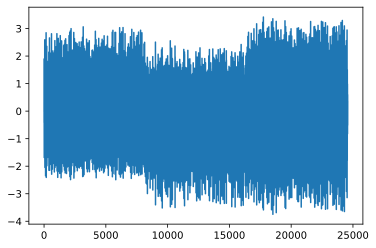

In [2]:
Fdict = {
    'mystery_1':[[328, 2208, 2885],[27,80,575]],
    'mystery_2':[[504, 868, 2654],[62,   108,  299]],
    'mystery_3':[[700, 1220, 2600],[130,   70,  160]]
    } # Formant frequencies in Hz

def excitation(f0,jitt,dur,nharm=None,unvoiced=False):
    w0T = 2*np.pi*f0/fs

    if nharm == None:
        nharm = int((fs/2)/f0) # number of harmonics
    nsamps = fs*dur
    sig = np.zeros(nsamps)
    ph = np.random.uniform(size=nsamps)*2*np.pi
    n = np.arange(nsamps)

    if unvoiced:
        sig = np.random.normal(size=nsamps)
    else:
    # Synthesize bandlimited impulse train
        for i in range(1,nharm):
            sig = sig + np.cos(i*w0T*n + jitt*ph)
    
    sig = sig/max(sig)
    return sig

def voca(sig,F,Fb):
    R = np.exp(-np.pi*Fb/fs);     # Pole radii
    theta = 2*np.pi*F/fs;     # Pole angles
    poles = R * np.exp(1j*theta) # Poles[B,A] = zpk2tf(0,np.concatenate((poles, np.conj(poles))),1) # Filter from zeros and poles
    
    [B,A] = si.zpk2tf(0,np.concatenate((poles, np.conj(poles))),1) # Filter from zeros and poles

    speech = si.lfilter(B, A, sig)
    speech = speech/np.std(speech)
    return speech,B,A

fs = 8192 # 22050  % Sampling rate in Hz ("telephone quality" for speed)

vowels = list(Fdict.keys())
f0 = 150 # Pitch in Hz
dur = 1 #one second in duration
ji = 0.1 #0.1
ex = excitation(f0,ji,dur)

text = ['mystery_1','mystery_2','mystery_3']

speech = np.zeros(1)
for t in text:
    F = np.array(Fdict[t][0])
    Fb = np.array(Fdict[t][1])
    print(t)

    vow,B,A = voca(ex,F,Fb)
    speech = np.concatenate((speech,vow))

speech = speech/np.std(speech)
plt.plot(speech)

In [3]:
ipd.Audio(speech, rate=fs) 

##### Question 1 (10 points)

Based on the audio output, what vowels were synthesized as mystery_1, mystery_2, and mystery_3? 
Please specify using a word; for example, if you heard an 'oo' sound as in 'hoot', you may answer with the word "hoot". 

mystery_1: yeet

mystery_2: oh

mystery_3: ah

Now we will examine just one vowel in greater detail. 
Select one mystery vowel to analyze below: 

mystery_1


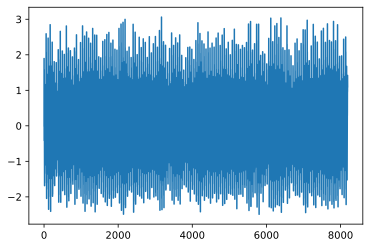

In [4]:
%matplotlib inline  

### Modify the line below:
text = ['mystery_1']

speech = np.zeros(1)
for t in text:
    F = np.array(Fdict[t][0])
    Fb = np.array(Fdict[t][1])
    print(t)

    vow,B,A = voca(ex,F,Fb)
    speech = np.concatenate((speech,vow))

speech = speech/np.std(speech)
plt.plot(speech)

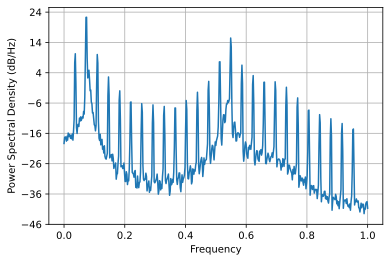

In [5]:
# Plot the power spectral density (PSD)
plt.psd(speech, 1024)
plt.show()

[ 1.         -0.72261975  0.55674926 -1.28704706  0.44930944 -0.27181726
  0.63621068 -0.13994806  0.11344886 -0.01970345  0.05659323]


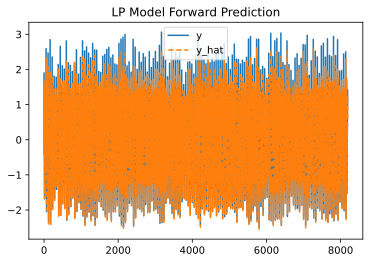

In [6]:
lpc_order = 10
s = speech

a = librosa.core.lpc(s, order = lpc_order)
print(a)
s_hat = scipy.signal.lfilter([0] + -1*a[1:], [1], s)
s_err = s[1:] - s_hat[:-1]
plt.plot(s[1:])
plt.plot(s_hat[:-1], linestyle='--')
plt.legend(['y', 'y_hat'])
plt.title('LP Model Forward Prediction')
plt.show()

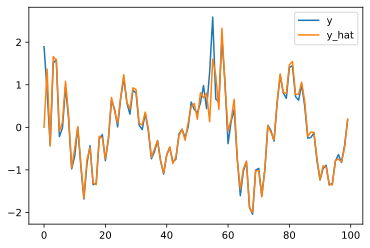

In [7]:
plt.plot(s[1:101])
plt.plot(s_hat[:100])
plt.legend(['y', 'y_hat'])
plt.show()

##### Question 2 (10 points)

What is being visualized as y and y_hat on the above plot?

``` Your response here ```

Frequency. `y` is the original signal; `y_hat` is the one ["filtered along one-dimension with an IIR or FIR filter."](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy-signal-lfilter)

/home/r8chen/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


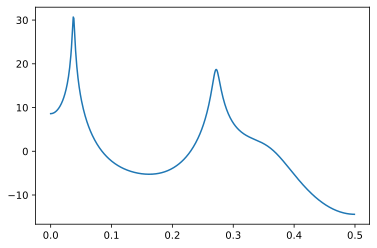

In [8]:
w,h = si.freqz(b=1,a = a, fs=1)
plt.plot(w,20*np.log10(h))

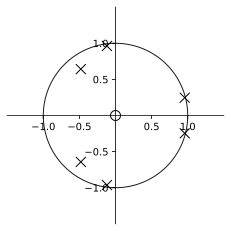

In [9]:
z,p,k = si.tf2zpk(B,A)
    
unit_circle = patches.Circle((0,0), radius=1, fill=False, color='black', ls='solid', alpha=0.9)
ax = plt.subplot(111)
ax.add_patch(unit_circle)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)    
    
plt.plot(z.real, z.imag, 'ko', fillstyle='none', ms = 10)
plt.plot(p.real, p.imag, 'kx', fillstyle='none', ms = 10)

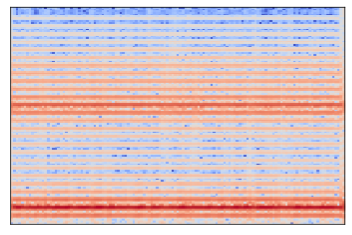

In [10]:
D = np.abs(librosa.stft(s,n_fft=256,hop_length = 64))
ld.specshow(librosa.amplitude_to_db(D))

##### Question 3 (20 points)

Record yourself speaking the same vowel sound you analyzed above. 
Graph the power spectral density (PSD) of your recording alongside the PSD of the synthetic signal. 

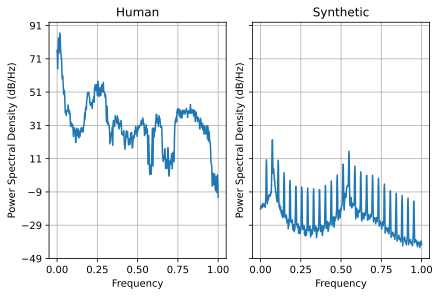

In [11]:
### Your Code Here

_, speech_human = wavfile.read("mystery_1.wav")

fig, axes = plt.subplots(
    nrows = 1, ncols = 2, 
    sharex = True, sharey = True,
    constrained_layout = True
)

axes[0].set(title = 'Human')
axes[0].psd(speech_human, NFFT = 1024)

axes[1].set(title = 'Synthetic')
axes[1].psd(speech, NFFT = 1024)

fig.show()

##### Question 4 (10 points)

How does the power spectral density of your recorded signal compare to the LPC spectrum? 

``` Your response here ```

"Human" has overall relatively higher spectral density and variance; "Synthetic" is more predictable but has equally sized spikes.

# Simple Singing Vocoder

In this section we will use a spoken sound to process an excitation that plays a melody. In music such an effect is known as vocoding and it is used to produce a talking musical instrument. 

In [12]:
def lpc_to_formants(lpc, sr):    
    """Convert LPC to formants    
    """
        
    # extract roots, get angle and radius
    roots = np.roots(lpc)
    
    pos_roots = roots[np.imag(roots)>=0]
    if len(pos_roots)<len(roots)//2:
        pos_roots = list(pos_roots) + [0] * (len(roots)//2 - len(pos_roots))
    if len(pos_roots)>len(roots)//2:
        pos_roots = pos_roots[:len(roots)//2]
    
    w = np.angle(pos_roots)
    a = np.abs(pos_roots)
    
    order = np.argsort(w)
    w = w[order]
    a = a[order]
    
    freqs = w * (sr/(2*np.pi))
    bws =  -0.5 * (sr/(2*np.pi)) * np.log(a)    
    
    # exclude DC and sr/2 frequencies
    return freqs, bws

##### Questioon 5 [10 points] 

Record yourself speaking slowly the sentence "Mister Blue Sky". Plot a spectrogram of the speech sound.

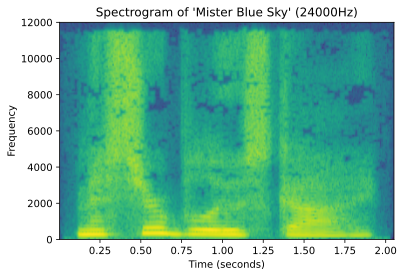

In [13]:
# Your code here
sr, sample = wavfile.read('mister_blue_sky.wav')

fig, ax = plt.subplots()

ax.specgram(sample, Fs = sr)
ax.set(
    title = f'''Spectrogram of 'Mister Blue Sky' ({sr}Hz)''',
    xlabel = 'Time (seconds)', ylabel = 'Frequency'
)

fig.show()

In [14]:
ipd.Audio(sample, rate=sr) 

##### Question 6 [30 points]

In this question we will create a song based on the spoken sentence you recorded. You will choose the melody by creating a sequence of pitches that change slowly over time.
Write a function that does the following:

1. Divide the speech signal into short slices (frames) of 512 samples with 50% overlap
2. For each speech segment compute formants by converting lpc_to_formants (F,Fb)
3. Choose a pitch (f0) for each segment
4. Using the voca function, create a speech sound (vow) from an excitation (ex) with that pitch
4. Overlap and add the sound segments with cross-fade window to create one long sound file 

You are free to alter the durations of the segments and choice of notes for the melody. 
Note that the notes should be relatively long (f0 should not change very often).

Cross-fade between segments can be done by applying a traingular (numpy.bartlett) or raised cosine (numpy.hanning) window to each segment before.

In [15]:
# Read the speech file
#sr, wave = wavfile.read("mister_blue_sky.wav")
wave, sr = librosa.load("mister_blue_sky.wav")

# precompute the hamming window
frame_len = 2048#512
window = scipy.signal.hann(frame_len)
vocode = np.zeros(len(wave+frame_len))

def _excitation(f0,jitt,dur,fs,nharm=None,unvoiced=False):
    w0T = 2*np.pi*f0/fs

    if nharm == None:
        nharm = int((fs/2)/f0) # number of harmonics
    nsamps = int(fs*dur)
    sig = np.zeros(nsamps)
    ph = np.random.uniform(size=nsamps)*2*np.pi
    n = np.arange(nsamps)

    if unvoiced:
        sig = np.random.normal(size=nsamps)
    else:
    # Synthesize bandlimited impulse train
        for i in range(1,nharm):
            sig = sig + np.cos(i*w0T*n + jitt*ph)
    
    sig = sig/max(sig)
    return sig

lpc_order = 10
pitch_fn = lambda curr, i: (
    250 * (1 + np.random.uniform(-.5, 1)) 
        if curr is None or i % 200 == 0
        else curr    
)

pitch = None
# 50% window steps for overlap-add
for i in range(0,len(wave),frame_len//2):
    wave_slice = wave[i:i+frame_len]
        
    ### Your Code Here
    if len(wave_slice) != frame_len:
        continue
    window = scipy.signal.hann(len(wave_slice))
    
    F, Fb = lpc_to_formants(
        librosa.core.lpc(wave_slice, order = lpc_order), 
        sr = sr
    )
    
    pitch = pitch_fn(pitch, i)
    ex = _excitation(
        f0 = pitch,
        fs = sr, dur = len(wave_slice) / sr,
        jitt = 0
    )
    vow, _, _ = voca(ex, F, Fb)
    
    vocode[i:i+frame_len] += vow * window

#wavfile.write("mister_blue_sky_song.wav", sr, vocode[:len(wave)])
song = vocode[:len(wave)]
ipd.Audio(song, rate=sr) 

In [16]:
wavfile.write('mister_blue_sky_song.wav', rate = sr, data = song)

##### Question 7 [10 points]

Why did we use overlapping windows for vocoder? 

``` your response here ```

We use overlapping windows for cross-fade between segments so that the segments will transition more smoothly.